## Read the data from RDS file

In [1]:
library(WGCNA)
library(reshape2)
library(stringr)
library(dplyr)
library(ggplot2)
library(tidyr)
# 
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()

## Allowing parallel execution with maximum threads


# Deseq2的varianceStabilizingTransformation

# exprMat <- './csv/reduced_assay_vst_shoot_3DMs_Mine_20220421.csv'

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




Allowing parallel execution with up to 127 working processes.


In [2]:
dataExpr <- readRDS('./Rdata/vst.Rds') %>% as.data.frame 
# dataExpr

In [3]:
map_id_name <- read.csv('../gene_table_and_other_scripts/bioMartR_Ath_all_genes_info_googled.csv')
map_id_name <- map_id_name %>% dplyr::rename('gene_name' = 'external_gene_name', 'gene_id' = 'ensembl_gene_id')
sample_n(map_id_name, 2)

gene_id,gene_name
<chr>,<chr>
AT2G07995,AT2G07995
AT1G63150,AT1G63150


In [4]:
map_id_name %>% filter(gene_name %>% str_detect('^\\d'))

gene_id,gene_name
<chr>,<chr>
AT5G38120,4CL8
AT5G13050,5-FCL
AT3G21240,4CL2
AT2G26260,3BETAHSD/D2
AT1G51680,4CL1
AT4G23800,3xHMG-box2
AT1G65060,4CL3
AT1G47510,5PTASE11
AT1G03410,2A6


In [5]:
source('../gene_table_and_other_scripts/theme_Publication.R')

Registering fonts with R

aakar already registered with pdfFont().

Abyssinica SIL already registered with pdfFont().

Andale Mono already registered with pdfFont().

Ani already registered with pdfFont().

AnjaliOldLipi already registered with pdfFont().

Arial already registered with pdfFont().

Arial Black already registered with pdfFont().

Chandas already registered with pdfFont().

Comic Sans MS already registered with pdfFont().

Courier New already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Mono already registered with pdfFont().

DejaVu Serif already registered with pdfFont().

Dhurjati already registered with pdfFont().

Droid Sans Fallback already registered with pdfFont().

Dyuthi already registered with pdfFont().

FreeMono already registered with pdfFont().

FreeSans already registered with pdfFont().

FreeSerif already registered with pdfFont().

Gargi already registered with pdfFont().

Garuda already registered with pdfFont(

In [6]:
Ath_TFs <- read.csv('../3DMs_pathogen/TFs/Ath_TF_list.txt', sep = '\t')

In [7]:
WGCNA_export_path <- './WGCNA_output_all'

create_directory_if_not_exists <- function(dir_path) {
  # Check if the directory exists; if not, create the directory
  if (!file.exists(dir_path)) {
    dir.create(dir_path, recursive = TRUE)
  }
}

create_directory_if_not_exists(WGCNA_export_path)

plots_path <- paste0(WGCNA_export_path, "/plots/")
create_directory_if_not_exists(plots_path)

In [8]:

type = "signed"

# cor
#  biweight mid-correlation & bicor
# corType: pearson or bicor

corType = "bicor"

corFnc = ifelse(corType=="pearson", cor, bicor)

maxPOutliers = ifelse(corType=="pearson",1,0.05)


robustY = ifelse(corType=="pearson",T,F)

In [9]:
head(dataExpr, 2)
dim(dataExpr)

,DM1/DM2d_1,Col-0_12_1,DM1/DM2d_2,Col-0_12_2,DM1/DM2d_3,DM6/DM7_1,Col-0_14_1,DM6/DM7_2,Col-0_14_2,DM6/DM7_3,⋯,S12-C,M20-A,M20-B,M20-C,R20-A,R20-B,R20-C,S20-A,S20-B,S20-C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT1G30814,7.854118,7.134483,8.072488,6.900123,7.904952,7.665448,6.900123,7.926750,6.900123,7.668472,⋯,7.743128,6.900123,6.900123,6.900123,8.713060,8.689767,8.708205,8.756711,8.550218,8.408096
AT1G78930,8.322251,9.048173,7.991578,9.229448,8.210870,8.598738,8.638332,8.435372,8.537098,8.585173,⋯,9.917472,9.263148,9.600597,9.649772,9.020265,8.666605,8.992366,8.878447,9.007046,8.962624


[1] 27270    71

In [10]:
sample_names <- data.frame(name = rownames(dataExpr)  )

In [11]:
sample_names %>% mutate(name2 = name %>% str_remove('_[\\dA-Za-z]$') %>% str_remove('-[\\dA-Za-z]$')) %>%
    group_by(name2) %>% summarise(n = n())
    

name2,n
<chr>,<int>
AT1G01010,1
AT1G01020,1
AT1G01030,1
AT1G01040,1
AT1G01046,1
AT1G01050,1
AT1G01060,1
AT1G01070,1
AT1G01080,1


### remove DM10/DM11 samples

In [12]:
# dataExpr <- dataExpr %>% dplyr::select(!matches('Tuescha|Cdm|DM11'))

## Check samples: all samples look evenly

In [13]:
options(repr.plot.width=12, repr.plot.height=8)
pdf(file = paste0(plots_path, "sapmle_barplot_", Sys.time(), '.pdf'),  wi = 12, he = 8)
boxplot(dataExpr) 
dev.off()

png 
  2

## choose top 20% most variable genes accross all samples

In [14]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.8))[2],0.01)),]

## transpose, the genes are column
dataExpr <- as.data.frame(t(dataExprVar))


gsg = goodSamplesGenes(dataExpr, verbose = 3)

##  Flagging genes and samples with too many missing values...
##   ..step 1
gsg$allOK
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}

nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)

dim(dataExpr)

## [1]  134 2697

head(dataExpr)[,1:8]

##       MMT00000051 MMT00000080 MMT00000102 MMT00000149 MMT00000159
## F2_2  -0.02260000 -0.04870000  0.17600000  0.07680000 -0.14800000
## F2_3   0.06170000  0.05820000 -0.18900000  0.18600000  0.17700000

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

[1]   71 5454

,AT1G69810,AT1G52200,AT1G71890,AT1G80870,AT1G47900,AT1G19715,AT1G53625,AT1G51440
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DM1/DM2d_1,9.265026,14.09817,8.237040,8.575142,9.509747,8.859563,10.642340,6.900123
Col-0_12_1,8.131310,11.82631,8.037637,9.112330,11.301110,10.732077,7.288023,8.839410
DM1/DM2d_2,9.240087,14.07083,8.193998,8.586995,9.567334,8.988276,10.594132,7.112101
Col-0_12_2,8.231868,11.55445,8.287390,9.239839,11.237102,10.679388,7.070480,8.382313
DM1/DM2d_3,9.126552,13.90354,8.347767,8.610593,9.665241,8.880352,10.448508,7.048042
DM6/DM7_1,9.278535,12.28272,8.805269,10.139657,9.532483,11.130371,9.727366,7.366667


In [15]:
gene.names <- colnames(dataExpr)
head(gene.names)

[1] "AT1G69810" "AT1G52200" "AT1G71890" "AT1G80870" "AT1G47900" "AT1G19715"

### Sample Clustering

png 
  2

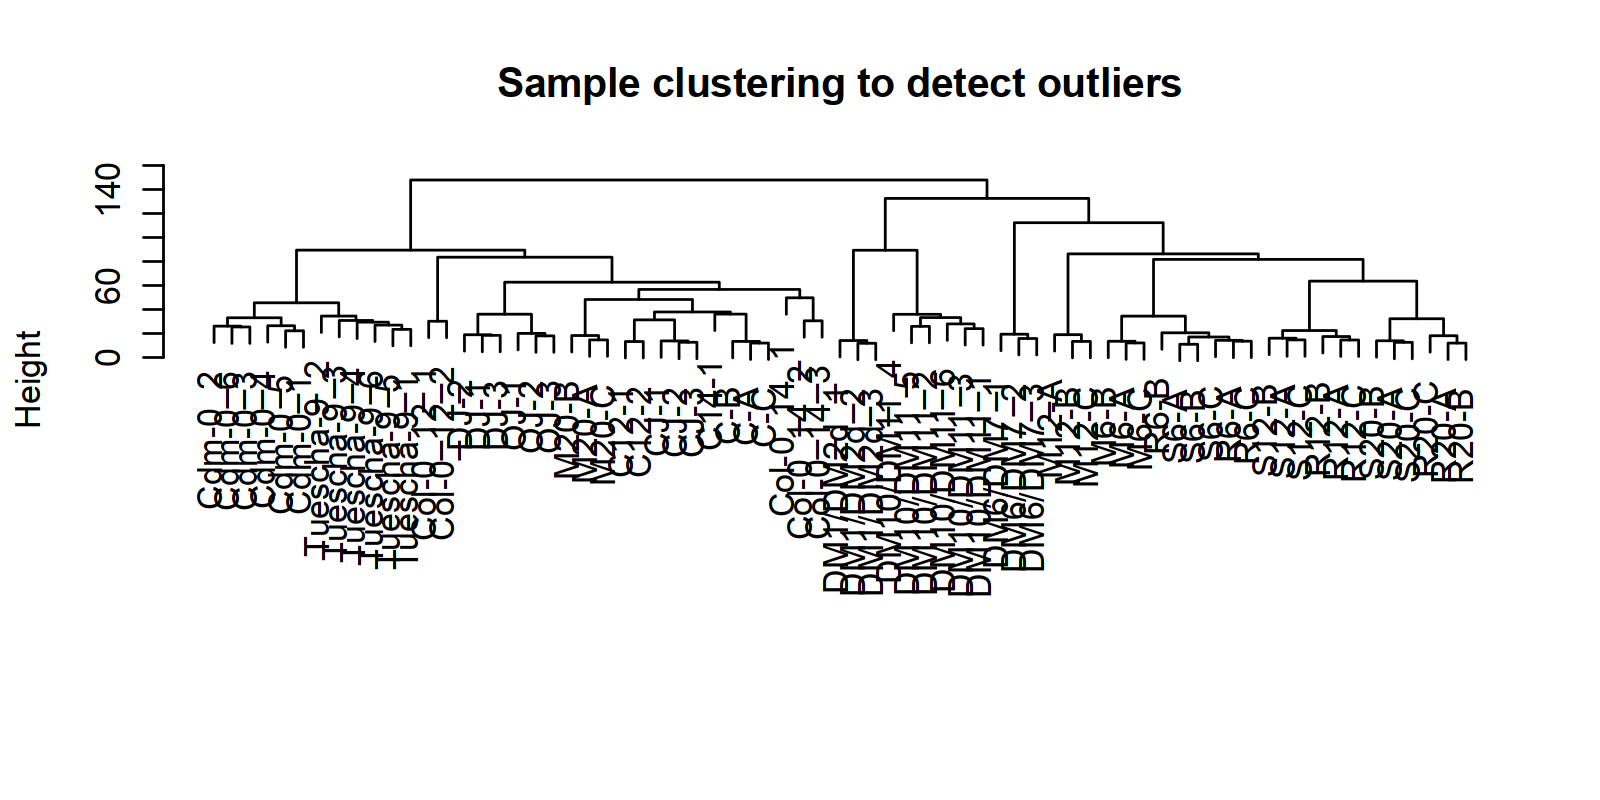

In [16]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 200)
## 查看是否有离群样品
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

pdf(file = paste0(plots_path, 'sample_clustering',Sys.time(), '.pdf'), width = 9.5, height = 4)
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex= 0.7)
dev.off()

## Determine Soft threshold (power)

http://pklab.med.harvard.edu/scw2014/WGCNA.html

pickSoftThreshold: will use block size 5454.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5454 of 5454
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.28500  9.8800        0.96800    2770    2780.0   3030
2      2  0.85400  5.2000        0.83400    1900    1960.0   2210
3      3  0.91300  2.2300        0.89000    1470    1560.0   1880
4      4  0.87800  1.3300        0.85500    1190    1300.0   1660
5      5  0.72100  0.8310        0.64800    1000    1100.0   1510
6      6  0.48700  0.5080        0.34000     858     948.0   1390
7      7  0.22000  0.2870        0.00636     745     823.0   1290
8      8  0.04070  0.1150       -0.20300     654     720.0   1200
9      9  0.00407 -0.0391       -0.21100     579     634.0   1120
10    10  0.04900 -0.1420       -0.11500     516     561.0   1050
11    12  0.17900 -0.3170        0.11900     417     445.0    925
12    14  0.28700 -0.4320        0.30500     343     

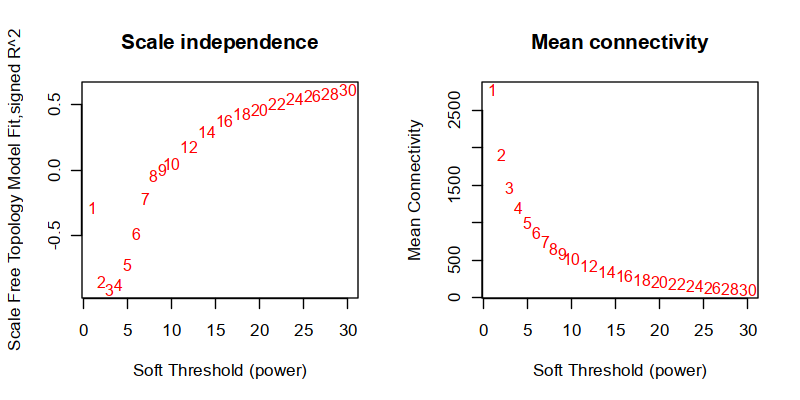

In [17]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 100)

powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")

# Soft threshold与平均连通性
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [18]:
power = sft$powerEstimate
power

[1] 2

### construct network, decide power

In [19]:
### 无向网络在power小于15或有向网络power小于30内，没有一个power值可以使
### 无标度网络图谱结构R^2达到0.8，平均连接度较高如在100以上，可能是由于
### 部分样品与其他样品差别太大。这可能由批次效应、样品异质性或实验条件对
### 表达影响太大等造成。可以通过绘制样品聚类查看分组信息和有无异常样品。
### 如果这确实是由有意义的生物变化引起的，也可以使用下面的经验power值。
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}
power

[1] 2

In [20]:
print(paste('calculating power = ' , power) )

[1] "calculating power =  2"


### Generating adjacency and TOM similarity matrices based on the selected softpower

#### manually assign power if softpowder doesn't work

In [21]:
softPower = 14;

#calclute the adjacency matrix
adj= adjacency(dataExpr,type = type, power = softPower);

#turn adjacency matrix into topological overlap to minimize the effects of noise and spurious associations
TOM=TOMsimilarityFromExpr(dataExpr,networkType = type, TOMType = type, power = softPower);

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [22]:
colnames(TOM) =rownames(TOM) = gene.names
dissTOM=1-TOM

In [23]:
library(flashClust)


Attaching package: ‘flashClust’


The following object is masked from ‘package:fastcluster’:

    hclust


The following object is masked from ‘package:stats’:

    hclust




In [24]:
geneTree = flashClust(as.dist(dissTOM),method="average")

In [25]:
options(repr.plot.width=14, repr.plot.height=10, repr.plot.res = 140)
# Set the minimum module size
minModuleSize = 30

# Module identification using dynamic tree cut

#dynamicMods = cutreeDynamic(dendro = geneTree,  method="hybrid", distM = dissTOM, 
#                            minClusterSize = minModuleSize);
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, method="hybrid", deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize);

#default deepSplit = 2

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)


dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

# plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

 ..cutHeight not given, setting it to 0.992  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1202  727  581  546  381  300  293  293  285  125   93   84   63   60   58   55 
  17   18   19   20   21   22   23 
  55   54   50   44   38   34   33 

dynamicColors
        black          blue         brown          cyan     darkgreen 
          293           727           581            60            34 
      darkred darkturquoise         green   greenyellow        grey60 
           38            33           381            93            55 
    lightcyan    lightgreen   lightyellow       magenta  midnightblue 
           55            54            50           285            58 
         pink        purple           red     royalblue        salmon 
          293           125           300            44            63 
          tan     turquoise        yellow 
           84          1202           546 

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


dynamicMods
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1202  727  581  546  381  300  293  293  285  125   93   84   63   60   58   55 
  17   18   19   20   21   22   23 
  55   54   50   44   38   34   33 

dynamicColors
        black          blue         brown          cyan     darkgreen 
          293           727           581            60            34 
      darkred darkturquoise         green   greenyellow        grey60 
           38            33           381            93            55 
    lightcyan    lightgreen   lightyellow       magenta  midnightblue 
           55            54            50           285            58 
         pink        purple           red     royalblue        salmon 
          293           125           300            44            63 
          tan     turquoise        yellow 
           84          1202           546 

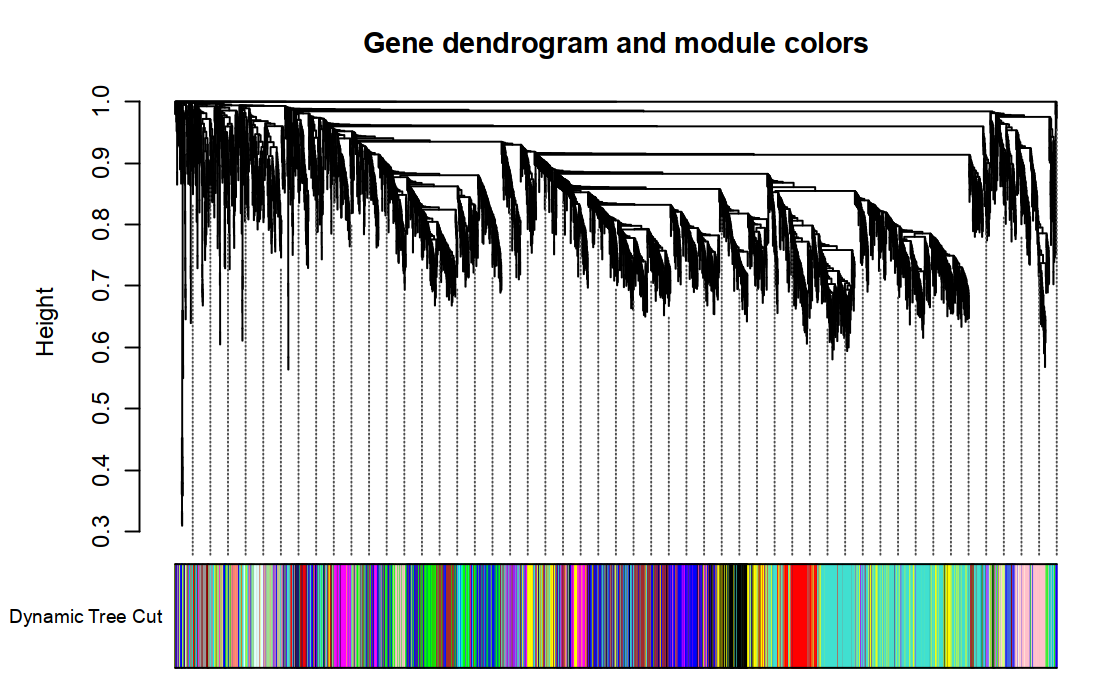

In [26]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 140)

#discard the unassigned genes, and focus on the rest
restGenes= (dynamicColors != "grey")
diss1=1-TOMsimilarityFromExpr(dataExpr[,restGenes], power = softPower)

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)

#Plot the module assignment under the dendrogram; note: The grey color is reserved for unassigned genes
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

colnames(diss1) =rownames(diss1) = gene.names[restGenes]
hier1=flashClust(as.dist(diss1), method="average" )
plotDendroAndColors(hier1, dynamicColors[restGenes], "Dynamic Tree Cut", dendroLabels = FALSE, 
                    hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

## merged mod

https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-man.pdf

In [27]:
# Calculate eigengenes
MEList = moduleEigengenes(dataExpr, colors = dynamicColors)
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
# Plot the result
sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
xlab = "", sub = "")

MEDissThres = 0.25 #0.25 default
# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")
# Call an automatic merging function
merge = mergeCloseModules(dataExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors;
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs;


 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 23 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


In [28]:
table(mergedColors)

mergedColors
         blue          cyan     darkgreen       darkred darkturquoise 
         2222          2490            84            93            33 
  greenyellow  midnightblue        purple        salmon           tan 
           93            58           234            63            84 

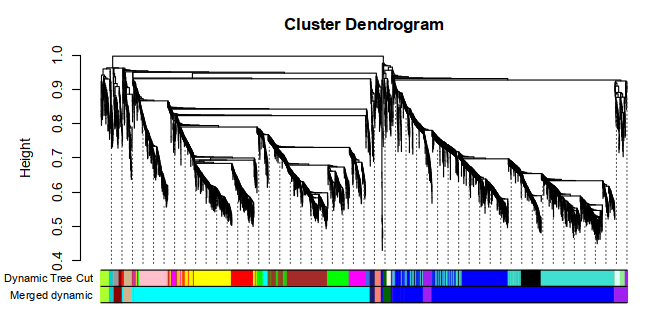

In [29]:

options(repr.plot.width=8.3, repr.plot.height=4, repr.plot.res = 80)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
                     autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

In [30]:
#sizeGrWindow(12, 9)
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.5, he = 5)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)
dev.off()

png 
  2

In [31]:
library(extrafont)

# Set global font size and family
par(cex=0.8, family="Arial")

# Save the plot
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.3, he = 5, family = "Arial")

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    autoColorHeight = FALSE,    
                    colorHeight = 0.16,
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

dev.off()


png 
  2

In [32]:
hubs = chooseTopHubInEachModule(dataExpr, colorh=  mergedColors, power=power, type=type)
hubs

blue          cyan     darkgreen       darkred darkturquoise 
  "AT1G75680"   "AT5G42010"   "AT3G15940"   "AT2G39330"   "AT5G14580" 
  greenyellow  midnightblue        purple        salmon           tan 
  "AT5G27890"   "AT3G11010"   "AT4G27030"   "AT3G44670"   "AT5G24470"

## export module hub genes from, sorted by connectivity

In [33]:
# the grey module is omitted
topHubs <- function (datExpr, colorh, omitColors = "grey", power = 2, type = "signed", 
    ...) 
{
    # modified from chooseTopHubInEachModule, but return the table of all genes connectivity
    isIndex = FALSE
    modules = names(table(colorh))
    if (!is.na(omitColors)[1]) 
        modules = modules[!is.element(modules, omitColors)]
    if (is.null(colnames(datExpr))) {
        colnames(datExpr) = 1:dim(datExpr)[2]
        isIndex = TRUE
    }
    
    connectivity_table <- data.frame(matrix(ncol = 3)) %>% setNames(c('gene', 'connectivity_rowSums_adj', 'module'))
    hubs = rep(NA, length(modules))
    names(hubs) = modules
    for (m in modules) {
        adj = adjacency(datExpr[, colorh == m], power = power, 
            type = type, ...)

        hub = which.max(rowSums(adj))

        hubs[m] = colnames(adj)[hub]

        sorted_genes <- rowSums(adj) %>% sort(decreasing = T) %>% as.data.frame()  %>%  
                tibble::rownames_to_column() %>% setNames(c('gene', 'connectivity_rowSums_adj')) %>% mutate(module = m)
        connectivity_table <- connectivity_table %>% rbind(sorted_genes)



    }
    if (isIndex) {
        hubs = as.numeric(hubs)
        names(hubs) = modules
    }
    return(connectivity_table %>% na.omit)
}

In [34]:
connectivity_table= topHubs(dataExpr, colorh=  mergedColors, power=power, type=type)

In [35]:
connectivity_table <- connectivity_table %>% left_join(map_id_name, by =c('gene' = 'gene_id'))

In [36]:
connectivity_table %>% group_by(module) %>% top_n(2, wt = connectivity_rowSums_adj)

gene,connectivity_rowSums_adj,module,gene_name
<chr>,<dbl>,<chr>,<chr>
AT1G75680,1824.90372,blue,GH9B7
AT1G55360,1819.23727,blue,-1803
AT5G42010,1955.10496,cyan,AT5G42010
AT1G63720,1954.52831,cyan,AT1G63720
AT3G15940,66.55779,darkgreen,Gene.ID#AT3G15940
AT3G19400,66.55244,darkgreen,AT3G19400
AT2G39330,76.82642,darkred,JAL23
AT3G16470,76.78207,darkred,JR1
AT5G14580,27.63659,darkturquoise,AT5G14580


In [37]:
top_50_each_module <- connectivity_table %>% group_by(module) %>% top_n(50, wt = connectivity_rowSums_adj)

In [38]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "connectivity_each_gene_in_module.xlsx"), overwrite = T)

Loading required package: openxlsx



In [39]:
# Rename to moduleColors
moduleColors = mergedColors
# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;
# Save module colors and labels for use in subsequent parts
#save(MEs, moduleLabels, moduleColors, geneTree, file = "FemaleLiver-02-networkConstruction-stepByStep.RData")

In [40]:
moduleColors %>% unique()
MEs %>% head(2)

[1] "cyan"          "purple"        "blue"          "darkred"      
 [5] "midnightblue"  "salmon"        "darkturquoise" "greenyellow"  
 [9] "darkgreen"     "tan"

,MEblue,MEpurple,MEdarkturquoise,MEcyan,MEdarkred,MEgreenyellow,MEsalmon,MEtan,MEdarkgreen,MEmidnightblue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DM1/DM2d_1,-0.20568039,-0.1557923,-0.2208651,0.16508252,-0.15081550,-0.06307087,0.197631192,0.02351471,0.15351248,0.200398583
Col-0_12_1,0.07341693,-0.0319329,-0.0755548,-0.06875897,-0.01812837,0.02593431,-0.005166699,0.07076801,0.01114131,0.006875687


In [41]:
#set the diagonal of the dissimilarity to NA 
diag(diss1) = NA;

#Visualize the Tom plot. Raise the dissimilarity matrix to the power of 4 to bring out the module structure
#sizeGrWindow(7,7)

pdf(file = paste0(plots_path, 'TOMplot' ,Sys.time(), '.pdf'),  wi = 6, he = 12)
TOMplot(diss1, hier1, as.character(moduleColors[restGenes]))
dev.off()

png 
  2

png 
  2

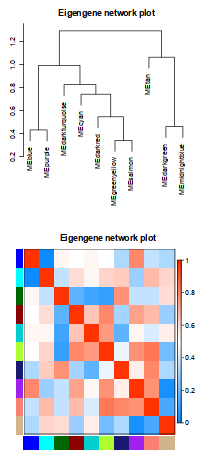

In [42]:
options(repr.plot.width=4.1, repr.plot.height=9, repr.plot.res = 50)

# Set up the font family and size
par(family = "Arial", cex = 0.8)

MEList = moduleEigengenes(dataExpr, colors = moduleColors)
MEs = MEList$eigengenes

# Plot with the specified font settings
plotEigengeneNetworks(MEs, "Eigengene network plot", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))

# Save the plot to a PDF file with the specified font settings
pdf(file = paste0(plots_path, 'ME_tree_' ,Sys.time(), '.pdf'),  wi = 3.1, he = 7.3, family = "Arial")
par(cex = 0.8)  # Set the font size to 8 points in the PDF device
plotEigengeneNetworks(MEs, "", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))
dev.off()


## Export Merged Moduels for Cytoscape

In [43]:
moduleColors %>% unique()

[1] "cyan"          "purple"        "blue"          "darkred"      
 [5] "midnightblue"  "salmon"        "darkturquoise" "greenyellow"  
 [9] "darkgreen"     "tan"

In [44]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
# Select modules
modules = c('purple','darkred','midnightblue','salmon',
            'darkturquoise','greenyellow','darkgreen','tan')
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [45]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
# Select modules
modules = moduleColors %>% unique()
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


## edges and nodes of top n each module 

In [46]:
top_50_each_module_edge <- cyt[[1]] %>% semi_join(top_50_each_module, by = c('fromNode' = 'gene')) %>% 
    semi_join(top_50_each_module, by = c('toNode' = 'gene'))
top_50_each_module_edge %>%    write.csv(paste0(node_edge_path, '/', "edges-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [47]:
top_50_each_module_edge_node <- cyt[[2]] %>% semi_join(top_50_each_module, by = c('nodeName' = 'gene')) 

top_50_each_module_edge_node %>%
    write.csv(paste0(node_edge_path, '/', "nodes-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [48]:
connectivity_table %>% group_by(module) %>% top_n(5, wt = connectivity_rowSums_adj) %>% 
    mutate(hub = 'yes') %>% write.csv(paste0(node_edge_path, '/', "5hub_each_module.csv"), row.names = F, quote = F)

In [49]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
create_directory_if_not_exists(node_edge_path)
for (color in moduleColors %>% unique()) {
    if (color == 'grey') {
        next }
    # Select modules
    modules = color
    # Select module probes
    probes = names(dataExpr)
    inModule = is.finite(match(moduleColors, modules));
    modProbes = probes[inModule];
    modGenes = modProbes
    # Select the corresponding Topological Overlap
    modTOM = TOM[inModule, inModule];

    dimnames(modTOM) = list(modProbes, modProbes)
    # Export the network into edge and node list files Cytoscape can read
    cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(  node_edge_path, color,'-', threshold_,  "-edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, color, '-', threshold_, "-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_ ,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])
}

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [50]:
create_directory_if_not_exists(WGCNA_export_path)

In [51]:
cyt_merged_0 = exportNetworkToCytoscape(TOM,
             edgeFile = paste(WGCNA_export_path,  "/0_all_mdoules_edges.txt", sep=""),
             nodeFile = paste(WGCNA_export_path, "/0_all_mdoules_nodes.txt", sep=""),
             weighted = TRUE, threshold = 0,
             nodeNames = probes, nodeAttr = moduleColors)
node_data <- cyt_merged_0$nodeData[, c(1,3)]
names(node_data) <- c('gene', 'module')
nrow(node_data)
node_data %>% sample_n(2)

[1] 5454

gene,module
<chr>,<chr>
AT4G34230,cyan
AT1G66725,cyan


In [52]:
node_n <- node_data %>% group_by(module) %>% summarise(n= n()) %>% mutate(module = paste0('ME', module))

## Module-trait relationships

In [53]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 

traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 
    `DM1/DM2d` = case_when(
  group2 %in% c("DM1/DM2d") ~ 1,
  group2 %in% c("Col-0_12") ~ -1), 
    
    `DM6/DM7` = case_when(
  group2 %in% c("DM6/DM7") ~ 1,
  group2 %in% c("Col-0_14") ~ -1),    
    
    `2DMs_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12") ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c( "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14" ) ~ -1), 
    
    `Col-0_adr1s` = case_when(
  group2 %in% c("Col-0_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `DM_adr1s_vs_Col-0_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c('Col-0_adr1s' ) ~ -1), 

    
    `2adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 
    
     `3adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s') ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
     `3adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s' ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1)
    
) 

traitData <- traits  %>%  select(`DM1/DM2d`,`DM6/DM7`,`2DMs_vs_WT`,`DM1_DM2d_adr1s`,
        DM1_DM2d_adr1s,`Col-0_adr1s`,`2adr1s_vs_WT`,
    `3adr1s_vs_WT`,`2adr1s_vs_DM`,`3adr1s_vs_DM`,
        `DM1/DM2d_vs_DM6/DM7`,`DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`, `DM_adr1s_vs_Col-0_adr1s`,
                                 DAS) #%>% filter(!grepl('Tuescha|Cdm|DM11', rownames(traits)))


traitData

ERROR: Error in parse(text = x, srcfile = src): <text>:60:1: unexpected symbol
59: 
60: traitData
    ^


In [ ]:
readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')

In [ ]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 

    `Rps4_vs_Rpt2_20h`  = case_when(
  group2 %in% c( "AvrRps4-20h") ~ 1,
  group2 %in% c("AvrRpt2-20h" ) ~ -1), 
    
  #   `Avr_vs_DM6/DM7_DM1/DM2d`  = case_when(
  # group2 %in% c("AvrRps4-20h",'AvrRpt2-20h' ) ~ 1,
  # group2 %in% c("DM1/DM2d", 'DM6/DM7') ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
    `DM_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c('Col-0_14', 'Col-0_12') ~ -1), 
    
        `Avr_vs_Mock` = case_when(
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ 1,
  group2 %in% c('Mock-20h' ) ~ -1), 
    
    `DM_vs_Avr` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ -1), 
      
    
    
) 

traitData <- traits  %>%  select(18:ncol(traits))


traitData

In [ ]:
rownames(MEs)

In [ ]:
MEs %>% nrow
# rownames(MEs)
# rownames(traitData)
all(rownames(MEs) == rownames(traitData))

In [ ]:
# Correlate traits --------------------------------------------------------
options(repr.plot.width=20, repr.plot.height=12, repr.plot.res = 140)
 
#Define number of genes and samples
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
#Recalculate MEs with color labels
MEs0 = moduleEigengenes(dataExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, traitData, use= "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

 
#Print correlation heatmap between modules and traits
textMatrix= paste(signif(moduleTraitCor, 2), "\n(",
                        signif(moduleTraitPvalue, 1), ")", sep= "")
dim(textMatrix)= dim(moduleTraitCor)

# par(mar= c(9, 15, 3, 3))
# module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
#             xLabels= names(traitData),
#             yLabels= names(MEs),
#             ySymbols= names(MEs),
#             colorLabels= FALSE,
#             colors= blueWhiteRed(20, gamma = 0.3, endSaturation = 0.3),
#             textMatrix= textMatrix,
#             setStdMargins= FALSE,
#             xLabelsAngle =35,
#             cex.text= 1,
#             zlim= c(-1,1),
#             main= paste("Module-trait relationships")
#                                           )

pdf(file = paste0(plots_path, "module_trait_merged.pdf"),  wi = 14, he = 9)

par(mar= c(9, 7, 3, 3))
module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
            xLabels= names(traitData),
            yLabels= names(MEs),
            ySymbols= names(MEs),
            colorLabels= FALSE,
            colors= blueWhiteRed(20, gamma =0.3 , endSaturation = 0.3),
            textMatrix= textMatrix,
            setStdMargins= FALSE,
            xLabelsAngle =35,
            cex.text= 1,
            zlim= c(-1,1),
            main= paste("Module-trait relationships")
                                          )

dev.off()

In [ ]:
names(traitData)

# customized trait plot

In [ ]:
module_trait_df <- moduleTraitCor %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Correlation') %>% 
    left_join(
        moduleTraitPvalue %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Pvalue'),
    by = c('Module' = 'Module', 'Trait' = 'Trait')) %>% 
    mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))),
          colors = Module %>% str_remove('ME')) %>% mutate(Trait = factor(Trait, levels = names(traitData)))

In [ ]:
module_trait_n  <- module_trait_df %>% select(Module) %>% distinct %>% 
    left_join(node_n, by = c('Module' = 'module')) %>% mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))))
module_colors <- setNames(as.character(unique(module_trait_df$colors)), unique(module_trait_df$Module))

In [ ]:
module_trait_n <- module_trait_n %>%
  mutate(Module_n = paste0(Module, '\nn=', n) ) %>% mutate(Module_n = factor(Module_n, levels = paste0(Module, '\nn=', n) ))

In [ ]:
module_colors['MEyellow'] = '#e5e64c'
module_colors['MEred'] = '#e84646'

In [ ]:
module_legend_grob2 <- ggplot(module_trait_n) +
    geom_tile(aes(x = 1, y = Module_n , fill = Module)) +
    scale_fill_manual(values = module_colors) +
    theme_classic() +
    theme(axis.line = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 10),
          axis.ticks = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          legend.position = "none") +
    labs(y = "Module") +
    coord_cartesian(clip = "off")
module_legend_grob2 <- ggplotGrob(module_legend_grob2)
# module_legend_grob2 %>% plot

In [ ]:
module_colors

In [ ]:
module_legend_grob2

In [ ]:
trait_plot_height = 8
trait_plot_width = 8.4
options(repr.plot.width=trait_plot_width, repr.plot.height= trait_plot_height, repr.plot.res = 200)
module_relationship_plot <- ggplot(module_trait_df, aes(x = Trait, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = paste0(round(Correlation, 2), "\n(", formatC(Pvalue, format = "e", digits = 0), ")")),
            size = 3, color = "black") +
  scale_fill_gradient2(low = "#5CB9FF", mid = "white", high = "#FF9E6A", midpoint = 0, limits = c(-1, 1),
                       guide = guide_colorbar(title = "Correlation", title.position = "top", title.hjust = 0.5)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 35, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        plot.margin = margin(9, 15, 3, 3, "pt")) +
  labs(x = "", y = "", title = "Module-trait relationships") +
  theme(axis.line  = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.y = element_blank()) +
  coord_cartesian(xlim = c(-2, length(unique(module_trait_df$Trait))), clip = 'off') +
  annotation_custom(grob = module_legend_grob2, xmin = -2, xmax = 0.5, ymin = 0.18, ymax = length(unique(module_trait_df$Module)) + 0.74)

module_relationship_plot
module_relationship_plot %>%  ggsave(file = paste0(plots_path, 'relationship', Sys.time(), '.pdf'), 
                    height = trait_plot_height, width = trait_plot_width)


In [ ]:
node_data %>% filter(gene %in% c('AT5G49450', 'AT1G23380', 'AT5G65510'))

In [ ]:
node_data %>% filter(module != 'grey')

In [ ]:
node_data %>% pull(module) %>%unique

In [ ]:
library('DOSE')
library("clusterProfiler")
library(gprofiler2)

In [ ]:
# Split the data frame into a list of named sublists by module
module_lists <- split(node_data$gene, node_data$module)
module_lists$black %>% length

In [ ]:
GOs = gost( module_lists,
      organism = "athaliana", sources = c("GO:BP", "GO:MF", "GO:CC", "KEGG"), multi_query = FALSE, evcodes = TRUE)

In [ ]:
# Define the function to process g:Profiler data
process_gprofiler_data <- function(df, include_terms_pattern = NULL, apply_filter = TRUE, cluster_order = NULL) {
  # Select relevant columns from the input dataframe
  gp_mod <- df$result[, c("query", "source", "term_id",
                          "term_name", "p_value", "query_size", 
                          "intersection_size", "term_size", 
                          "effective_domain_size", "intersection")]
  
  # Calculate GeneRatio and BgRatio
  gp_mod$GeneRatio <- paste0(gp_mod$intersection_size, "/", gp_mod$query_size)
  gp_mod$BgRatio <- paste0(gp_mod$term_size, "/", gp_mod$effective_domain_size)
  
  # Rename columns
  names(gp_mod) <- c("Cluster", "Category", "ID", "Description", "p.adjust", 
                     "query_size", "Count", "term_size", "effective_domain_size", 
                     "geneID", "GeneRatio", "BgRatio")
  
  # Replace commas with slashes in geneID column
  gp_mod$geneID <- gsub(",", "/", gp_mod$geneID)
  
  # Apply filter based on include_terms_pattern if apply_filter is TRUE
  if (apply_filter && !is.null(include_terms_pattern)) {
    gp_mod <- gp_mod %>% filter(str_detect(Description, include_terms_pattern))
  }
  
  # Capitalize the first letter of each word in the Description column
  gp_mod$Description <- stringr::str_replace(gp_mod$Description, "^\\w", stringr::str_to_title)
  
  # Factorize the Cluster column based on the input list (cluster_order)
  if (!is.null(cluster_order)) {
    gp_mod$Cluster <- factor(gp_mod$Cluster, levels = cluster_order)
  }

  # Return the modified dataframe
  return(gp_mod)
}

# Usage example:

# Define the terms to include
include_terms <- c('systemic acquired resistance', 'response to salicylic acid', 'response to oxidative stress',
                  'programmed cell death', 'defense response', 'response to hypoxia', 'chitin metabolic process',
                  'aminoglycan metabolic process', 'response to toxic substance', 'hydrogen peroxide catabolic process',
                  'detoxification',
                  'secretory vesicle', 'plasma membrane', 'extracellular region',
                  'tetrapyrrole binding', 'polysaccharide binding', 'peroxidase activity',
                  'Starch and sucrose metabolism', 'Plant-pathogen interaction', 'Phenylpropanoid biosynthesis'
                  )


# Create the include_terms_pattern
include_terms_pattern <- paste0("^(", paste(include_terms, collapse = "|"), ")$")


# Define the list to order Cluster column
# cluster_order <- c("DM10/DM11", "DM1/DM2d", "DM6/DM7", "DM1/DM2d_adr1s", "DM6/DM7_adr1s", "Col-0_adr1s")

# Process the GO_up and GO_down dataframes using the process_gprofiler_data function
GO_result <- process_gprofiler_data(GOs, include_terms_pattern, apply_filter = F )


In [ ]:
library(ggh4x)

In [ ]:
GO_result %>% arrange(p.adjust)

In [ ]:
# Function to create a customized dot plot
customize_dotplot <- function(data,
                              description_width = 40,
                              low_color = "#fe6865",
                              high_color = "#0fc3c7",
                              text_size = 10,
                              panel_spacing_y = 0.05,
                              dodge_labels = FALSE,
                              plot_title = "Customized Dot Plot") {
  
  # Wrap the Description text to a fixed width
  data$Description <- str_wrap(data$Description, width = description_width)
  
  # Calculate the proportions of unique Descriptions for each Category
  category_proportions <- data %>%
    group_by(Category) %>%
    summarise(n_unique_descriptions = n_distinct(Description)) %>%
    mutate(proportion = n_unique_descriptions / sum(n_unique_descriptions)) %>%
    pull(proportion)
    
  # Create the customized dot plot
  go_plot <- ggplot(data, aes(x = Cluster, y = reorder(Description, `p.adjust`), size = Count/query_size, color = `p.adjust`)) +
    geom_point() +
    scale_color_gradient(low = low_color, high = high_color) +
    facet_grid(Category ~ . , scales = "free_y",
               labeller = label_wrap_gen(width = description_width, multi_line = T)) +
    labs(title = plot_title,
         x = NULL, # Remove x-axis title
         y = NULL, # Remove y-axis title
         size = "Gene Ratio",
         color = "p.adjust") +
    theme_minimal() +
    theme(
      text = element_text(size = text_size, color = "black"),
      plot.title = element_text(size = text_size, color = "black"), # Set plot title font size
      legend.text = element_text(size = text_size, color = "black"), # Set legend font size
      strip.background = element_rect(fill = "grey80"),
      panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
      panel.spacing.y = unit(panel_spacing_y, "lines"), # Set space between facets
      legend.margin = margin(0, -10, 0, 0), # Reduced space between legend and plot
      axis.text.y = element_text(face = "bold"), # Bold Description
      axis.text.x = element_text(face = "bold", angle = ifelse(dodge_labels, 45, 0), hjust = ifelse(dodge_labels, 1, 0.5), vjust = ifelse(dodge_labels, 1, 0.5)), # Bold Cluster with optional dodging
      strip.text.y = element_text(face = "bold") # Bold facet name
    ) + 
    guides(size = guide_legend(order = 0),
           color = guide_colourbar(order = 1)) +
    force_panelsizes(rows = category_proportions)
  
  return(go_plot)
}

# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot
go_plot


In [ ]:
# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot

In [ ]:
go_plot_list <- list()
for (i in GO_result %>% pull(Cluster) %>% unique) {
   GO_result %>% filter(Cluster == i) %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
}

In [ ]:
# Create an empty list for storing the plots
go_plot_list <- list()

# Iterate through each unique value in the "cluster" column
for (i in unique(GO_result$Cluster)) {
  # Filter the data for the specific cluster value
  cluster_data <- GO_result %>% filter(Cluster == i)
  
  # Customize the dot plot and store it in a variable
  plot <- customize_dotplot(cluster_data, plot_title = 'modules', text_size = 8, dodge_labels = TRUE)
  
  # Append the plot to the go_plot_list
  go_plot_list[[paste0("Cluster_", i)]] <- plot
}


In [ ]:
# Load necessary libraries
library(gridExtra)
library(grid)
# Arrange the plots from go_plot_list in a grid with the specified dimensions
combined_plot <- arrangeGrob(grobs = go_plot_list, ncol = 2, width =8.4)

# Display the combined plot
# grid.draw(combined_plot)
combined_plot %>% ggsave(file = paste0(plots_path, 'GO_', Sys.time(), '.pdf'), height = 40, width = 8)

In [ ]:
node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% filter(module == 'MEsalmon') %>% left_join(map_id_name, by= c('gene' = 'gene_id')) %>% pull(gene_name)

In [ ]:
formula_GO_BP <- compareCluster( gene ~ module ,data = node_data,# %>% as.data.frame, 
                              OrgDb = "org.At.tair.db", 
                              fun = "enrichGO", ont="BP",
                              keyType="TAIR")

simplified_GO_BP <- simplify(formula_GO_BP, 
                       cutoff=0.5, # smaller,fewer category  0.4
                       by="p.adjust", select_fun = min,
  measure = "Wang",)

In [ ]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 160)

#somehow the levels of module is lost, level it again
GO_plot <- dotplot(simplified_GO_BP,
                   font.size = 10) + scale_x_discrete(guide = guide_axis(n.dodge = 2)) #+ theme_Publication()
GO_plot %>% ggsave(file = paste0(plots_path, "wgcna_GO_plot_2.pdf"), width=8, height=8)
GO_plot

# heatmap

In [ ]:
Res_combined <- readRDS('./Rdata/Res_combined.rds')
Res_combined

In [ ]:
Res_combined <- Res_combined  %>% right_join(node_data, by= c('AGI' = 'gene')) %>% 
    mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))

In [ ]:
Res_combined 

In [ ]:
Res_combined <- Res_combined %>% mutate(source = factor(source, levels = c('AvrRpt2-6h', 'AvrRpt2-12h', 'AvrRpt2-20h',
        'AvrRps4-6h', 'AvrRps4-12h', 'AvrRps4-20h',   'DM10/DM11',  'DM1/DM2d',  'DM6/DM7',
        'DM1/DM2d_adr1s', 'DM6/DM7_adr1s', 'Col-0_adr1s')))

In [ ]:
module_n <- node_data %>%  mutate(module = paste0('ME', module )) %>% 
    mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))%>% 
    group_by(module) %>% summarise(n =n())
module_list <- split(module_n$n, module_n$module)
names(module_list) <- module_n$module
module_list

In [ ]:
rownames(moduleTraitCor)

In [ ]:
Res_combined  %>% filter(module == 'MEdarkred')

In [ ]:
module_trait_n

In [ ]:
Res_combined <- Res_combined %>% left_join(module_trait_n, by = c('module' = 'Module') )

In [ ]:
Res_combined %>% mutate(Module_n = Module_n %>% str_replace('\n', ' '))

In [ ]:
#factor column Module_n as module #
Res_combined <- Res_combined %>%
  arrange(module) %>%
  mutate(Module_n = forcats::fct_inorder(as.character(Module_n)))

In [ ]:
Res_combined %>% pull(module) %>% unique

In [ ]:
module_colors <- list(
  "MEmidnightblue" = "#00009C",  # Substitute with your desired colors
  "MEdarkgreen" = "#006400",
  "MEtan" = "#D2B48C",
  "MEsalmon" = "#FA8072",
  "MEgreenyellow" = "#ADFF2F",
  "MEdarkred" = "#8B0000",
  "MEcyan" = "#00FFFF",
  "MEdarkturquoise" = "#00CED1",
  "MEpurple" = "#800080",
  "MEblue" = "#0000FF"
)


In [ ]:
width_ = 8.2
height_ = 7
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 100)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
         strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines") ## spacing between facets
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.png'), width = width_, height = height_ , dpi = 1200)

In [ ]:
module_list

In [ ]:
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 50)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines"), ## spacing between facets
        legend.position = "bottom"
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )


In [ ]:
library(ggplot2)
library(dplyr)

# Create a data frame
df <- data.frame(
  module = names(module_list_sqrt_plus),
  height = unlist(module_list_sqrt_plus),
  color = unlist(module_colors)
)

# Reorder factor levels
levels_order <- c('MEmidnightblue', 'MEdarkgreen', 'MEtan', 'MEsalmon', 'MEgreenyellow', 'MEdarkred', 'MEcyan', 'MEdarkturquoise', 'MEpurple', 'MEblue')
df$module <- factor(df$module, levels = levels_order)

# Compute y positions with a gap of 0.2 between each tile
df <- df %>%
  arrange(desc(module)) %>%
  mutate(ymin = cumsum(height) - height,
         ymax = cumsum(height) - 1.4)  # subtract 0.2 from ymax to create a space

# Create the plot
tiles <- ggplot(df, aes(fill = module, ymin = ymin, ymax = ymax)) +
  geom_rect(aes(xmin = 2, xmax = 4)) +
  scale_fill_manual(values = module_colors) +
  theme_classic() 

tiles
tiles %>% ggsave(file = paste0(plots_path, 'tiles', Sys.time(), '.pdf'), width = width_, height = height_ )


In [ ]:
df %>% select(module, color)

# biomart

In [ ]:
node_data_info <- node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% left_join(map_id_name , by =c('gene' = 'gene_id'))

In [ ]:
connectivity_table_info <- connectivity_table %>% arrange(desc(connectivity_rowSums_adj)) %>% 
    mutate(module = paste0('ME', module ))  %>% select(-gene_name) %>%
    left_join(map_id_name , by =c('gene' = 'gene_id'))

In [ ]:
connectivity_table_info <- connectivity_table_info %>% left_join (
    Res_combined  %>% distinct() %>% pivot_wider(names_from = source, values_from = log2FC) %>% dplyr::select(-module,  -n, -Module_n),
    by = c('gene' = 'AGI'))

In [ ]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table_info %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/connectivity_info.xlsx"), overwrite = T)

In [ ]:
connectivity_table_info %>% write.csv( paste0(WGCNA_export_path, "/connectivity_info.csv"), 
                                      row.names= F)

In [ ]:
connectivity_table_info %>% filter(gene == 'AT4G14400')

In [ ]:
connectivity_table_info %>% filter(gene == 'AT4G14390')

In [ ]:
library(biomaRt)
# library(Biostrings)
# library(BSgenome.Athaliana.TAIR.TAIR9)

In [ ]:
# Specify the genes of interest
genes_of_interest <- top_50_each_module$gene

# Use the BioMart database
plant_mart <- useMart(biomart = "plants_mart", host="https://plants.ensembl.org")
athaliana <- useDataset("athaliana_eg_gene", mart = plant_mart)

# Get the gene information
gene_info <- getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 'strand', 'start_position', 'end_position', 'transcription_start_site'),
                   filters = 'ensembl_gene_id',
                   values = genes_of_interest,
                   mart = athaliana)

# Separate dataframe by strand
strand_positive <- gene_info %>% filter(strand == 1)
strand_negative <- gene_info %>% filter(strand == -1)

# For strand == 1, keep row with min transcription_start_site
strand_positive <- strand_positive %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == min(transcription_start_site))

# For strand == -1, keep row with max transcription_start_site
strand_negative <- strand_negative %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == max(transcription_start_site))

# Combine the dataframes
gene_info_filtered <- bind_rows(strand_positive, strand_negative) %>%
    filter(ensembl_gene_id %>% str_detect('AT\\dG'))

In [ ]:
# Initialize an empty list to store the sequences
sequences <- list()

# Loop over the filtered gene info dataframe
for (i in 1:nrow(gene_info_filtered)) {
  # Get the current gene's info
  current_gene <- gene_info_filtered[i, ]
  
  # Calculate the start and end positions
  if (current_gene$strand == 1) {
    start <- current_gene$transcription_start_site - 1799
    end <- current_gene$transcription_start_site + 200
  } else {
    start <- current_gene$transcription_start_site - 200
    end <- current_gene$transcription_start_site + 1799
  }
  
  # Extract the sequence
  sequence <- getSeq(BSgenome.Athaliana.TAIR.TAIR9, 
                     names = paste0("Chr", current_gene$chromosome_name),
                     start = start,
                     end = end)
  
  # If the gene is on the negative strand, reverse complement the sequence
  if (current_gene$strand == -1) {
    sequence <- reverseComplement(sequence)
  }
  
  # Add the sequence to the list, with the gene ID as the name
  sequences[[current_gene$ensembl_gene_id]] <- sequence
}

# Convert the list to a DNAStringSet
sequences_set <- DNAStringSet(unlist(sequences))

# Add names to the DNAStringSet
names(sequences_set) <- names(sequences)

# Write the sequences to a FASTA file
writeXStringSet(sequences_set, filepath = paste0(WGCNA_export_path, '/', "promtoters.fasta"))



In [ ]:
plantregmap_top50_each_module <- read.csv('./plantregmap/plantTFBS_fimo.txt', sep = '\t') %>% 
    dplyr::select(1, 3) %>% dplyr::rename('TF' = 'X.pattern.name', 'target' = 'sequence.name' ) 

In [ ]:
plantregmap_top50_each_module <- plantregmap_top50_each_module %>% semi_join(top_50_each_module, by = c('TF' = 'gene')) %>%
    semi_join(top_50_each_module, by = c('target' = 'gene')) %>% group_by(TF, target) %>% 
    summarise(TF_weight = n()) %>% mutate(source = 'TF') 

  #  write.csv(paste0(WGCNA_export_path, 'TF_top50_each_module', ".csv"), row.names = F, quote = F)

In [ ]:
plantregmap_top50_each_module %>% dplyr::rename('fromNode' = 'TF', 'toNode' = 'target') %>% 
    mutate(direction = 'directed', weight = NA)  %>% rbind(
    top_50_each_module_edge %>% mutate(source = 'correlation', TF_weight = NA) %>%
    dplyr::select(-toAltName, - fromAltName)
    ) %>% write.csv(paste0(WGCNA_export_path,'/', 'TF+WGCNA_top50_each_module', ".csv"), row.names = F, quote = F)

## NLRs LRRs in WGCNA modules

In [ ]:
NLRs_and_TIRs <- read.csv(file = "../gene_table_and_other_scripts/NLRs_and_TIR_only.csv") %>%
    dplyr::rename('GeneFamily' = 'Class')

In [ ]:
NLRs_and_TIRs_connectivity_table_info <- connectivity_table_info %>% semi_join(NLRs_and_TIRs, by = c('gene'= 'AGI')) %>%
    left_join(NLRs_and_TIRs, by = c('gene'= 'AGI'))

In [ ]:
require(openxlsx)

NLRs_and_TIRs_connectivity_table_info %>% write.csv(paste0(WGCNA_export_path, '/','NLRs_and_TIRs_connectivity_table_info', ".csv"), row.names = F, quote = F)

wb <- createWorkbook()
for (i in NLRs_and_TIRs_connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, NLRs_and_TIRs_connectivity_table_info %>% filter(module == i) %>% arrange(GeneFamily))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/NLRs_and_TIRs_connectivity_table_info.xlsx"), overwrite = T)

In [ ]:
Pathways_Ngou_2021 <- readxl::read_excel("../gene_table_and_other_scripts/Ngou_2021_Nature_figure2E_pathways_mod.xlsx")

In [ ]:
Pathways <- Pathways_Ngou_2021 %>% dplyr::select(Target, GeneFamily)
Pathways <- Pathways %>%as.data.frame  %>% dplyr::rename('AGI' = 'Target')
LRRs <- Pathways %>% filter(GeneFamily %>% str_detect('LRR'))

In [ ]:
connectivity_table_info %>% semi_join(LRRs, by = c('gene'= 'AGI')) %>%
    left_join(LRRs, by = c('gene'= 'AGI'))  %>% write.csv(paste0(WGCNA_export_path, '/','LRRs_connectivity_table_info', ".csv"), row.names = F, quote = F)